In [1]:

import numpy as np
import pandas as pd
from scipy.sparse import hstack, vstack, csr_matrix
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from typing import Union, List

In [2]:
def write_to_submission_file(predicted_probs, out_file: str = 'to_submission.csv.zip',
                             target='target', index_label='session_id'):
    df = pd.DataFrame(predicted_probs,
                      index=np.arange(1, len(predicted_probs) + 1),
                      columns=[target])
    df.to_csv(out_file, index_label=index_label, compression="zip")

def convert_types(df: pd.DataFrame) -> pd.DataFrame:
    """ Define all type transformations in a single function """
    sites = [s for s in df.columns if "site" in s]
    df[sites] = df[sites].fillna(0).astype('uint16')
    times = [t for t in df.columns if "time" in t]
    df[times] = df[times].apply(pd.to_datetime)
    if 'target' in df.columns:
        df['target'] = df.target.astype('uint8')
    return df

train_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv.zip')
train_df = convert_types(train_df)
train_df.sort_values(by='time1', inplace=True)

test_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv.zip')
test_df = convert_types(test_df)

sites = [s for s in train_df.columns if 'site' in s]
times = [t for t in train_df.columns if 'time' in t]

# Our target variable
y_train = train_df["target"]

# United dataframe of the initial data
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

sites_corpus = full_df[sites].to_string(header=False, index=False).split('\n')

tfv = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train = tfv.fit_transform(sites_corpus[:idx_split])
X_test = tfv.transform(sites_corpus[idx_split:])

X_full = vstack([X_train, X_test]).tocsr()

In [3]:
def get_auc_logit_score(X, y, C=1.0, seed=17, n_splits=10):
    # Split the data into the training and validation sets
    time_split = TimeSeriesSplit(n_splits=n_splits)
    logit = LogisticRegression(C=C, random_state=seed, solver='liblinear')
    cv_scores = cross_val_score(logit, X, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
    return cv_scores.mean()

def get_auc_rf_score(X, y, seed=17, max_depth=10, n_estimators=10, 
                     n_splits=10, max_features='auto'):
    time_split = TimeSeriesSplit(n_splits=n_splits)
    rf = RandomForestClassifier(random_state=seed, 
                                max_depth=max_depth, 
                                max_features=max_features, 
                                n_estimators=n_estimators)
    cv_scores = cross_val_score(rf, X, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
    return cv_scores.mean()

def get_auc_rf_scores(X, y, seed=17, max_depth=10, n_estimators=10, 
                     n_splits=10, max_features='auto'):
    time_split = TimeSeriesSplit(n_splits=n_splits)
    rf = RandomForestClassifier(random_state=seed, 
                                max_depth=max_depth, 
                                max_features=max_features, 
                                n_estimators=n_estimators)
    cv_scores = cross_validate(rf, X, y, cv=time_split, scoring='roc_auc', 
                               return_train_score=True, n_jobs=-1)
    return cv_scores


def get_features(full_df) -> pd.DataFrame:
    times = [t for t in full_df.columns if 'time' in t]
    feat_df = pd.DataFrame(index=full_df.index)

    feat_df['weekday'] = full_df['time1'].dt.weekday
    for weekday in range(7):
        feat_name = f'weekday_{weekday}'
        feat_df[feat_name] = (full_df['time1'].dt.weekday == weekday).astype(int)
    for hour in range(23):
        feat_name = f'hour_{hour}'
        feat_df[feat_name] = (full_df['time1'].dt.hour == hour).astype(int)

    feat_df['duration'] = (full_df[times].max(axis=1) - full_df[times].min(axis=1)).dt.total_seconds()

    feat_df['hour_sin'] = np.sin(full_df['time1'].dt.hour / 24)
    feat_df['hour_cos'] = np.cos(full_df['time1'].dt.hour / 24)

    feat_df['hour'] = full_df['time1'].dt.hour

    feat_df['morning'] = feat_df['hour'].between(7, 11).astype(int)
    feat_df['noon'] = feat_df['hour'].between(12, 18).astype(int)
    feat_df['evening'] = feat_df['hour'].between(19, 23).astype(int)
    feat_df['night'] = feat_df['hour'].between(0, 6).astype(int)

    deltas = ['delta' + str(i) for i in range(1, 10)]    
    delta_df = (full_df[times] - full_df[times].shift(1, axis=1)) \
        .copy() \
        .drop(columns='time1') \
        .apply(lambda x: x.dt.total_seconds())

    delta_df.columns = deltas
    for delta in deltas:
        feat_df[delta] = delta_df[delta]

    feat_df['delta_avg'] = delta_df.mean(axis=1, skipna=True).fillna(0.0)

    best_hours = ['hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_14', 'hour_16', 'hour_17', 'hour_18',
                  'hour_19', 'hour_20', 'hour_21', 'hour_22']
    best_weekdays = ['weekday_0']
    best_previous = ['morning', 'noon', 'evening']

    return feat_df.fillna(0.0)

# Add the new feature to the sparse matrix
def add_feature(feat: str, X_sparse=None, standardize=True, onehot=False):
    tmp = feat_df[[feat]].values
    if onehot:
        enc = OneHotEncoder(dtype=np.uint8, sparse=False)
        tmp = enc.fit_transform(tmp)
    if standardize:
        tmp = StandardScaler().fit_transform(tmp)
    if X_sparse is not None:
        return hstack([X_sparse, tmp]).tocsr()
    else:
        return csr_matrix(tmp)


def add_multi_feature(feat_list: list, X_sparse=None):
    X_new = X_sparse
    for feat in feat_list:
        X_new = add_feature(feat, X_new)
    return X_new[:idx_split, :], X_new[idx_split:, :]


def test_feature(features: Union[list, str], standardize=True, onehot=False, C=1):
    print(f"Testing:\t{features}")

    if isinstance(features, str):
        features = [features]
    
    X_new = X_full
    for feat in features:
        X_new = add_feature(feat, X_new, onehot=onehot, standardize=standardize)
    X_train_new = X_new[:idx_split, :]
    score = get_auc_logit_score(X_train_new, y_train, C=C)

    print(f"Score:\t\t{score:.4f}\t", end="")

    if score > BASELINE:
        print(f"+++ baseline:\t{BASELINE:.4f}")
    else:
        print(f"--- baseline:\t{BASELINE:.4f}")
    return score


def test_multi_feature(feat_list: list, C=1):
    """
    Deprecated
    """
    print(f"Testing:\t{feat_list}")

    X_new = X_full
    for feat in feat_list:
        X_new = add_feature(feat, X_sparse=X_new)
    X_train_new = X_new[:idx_split, :]
    score = get_auc_logit_score(X_train_new, y_train, C=C)

    print(f"Score:\t\t{score:.4f}\t", end="")
    if score > BASELINE:
        print(f"+++ baseline: {BASELINE:.4f}")
    else:
        print(f"--- baseline: {BASELINE:.4f}")
    return score


def predict_probs(feat_list: list = None, n_splits=10, calc_local = True,
                  estimator=LogisticRegression(C=1, random_state=17, solver='liblinear')):
    X_new = X_full

    if feat_list is not None:
        for feat in feat_list:
            X_new = add_feature(feat, X_sparse=X_new)
    else:
        pass

    X_train_new = X_new[:idx_split, :]
    X_test_new = X_new[idx_split:, :]
    estimator.fit(X_train_new, y_train)

    if calc_local:
        time_split = TimeSeriesSplit(n_splits=n_splits)
        cv_scores = cross_val_score(estimator, X_train_new, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
        print(f"Local score: {cv_scores.mean():.4f}")
    return estimator.predict_proba(X_test_new)[:, 1]

In [4]:
%%time
BASELINE = get_auc_logit_score(X_train, y_train)

feat_df = get_features(full_df)

Wall time: 11.9 s


In [5]:
%%time
X_feat_only = add_multi_feature(feat_df.columns)[0]

Wall time: 19 s


In [50]:
%%time
get_auc_logit_score(X_feat_only, y_train)

Wall time: 22.2 s


0.8359167625505787

In [53]:
%%time
get_auc_rf_score(X_feat_only, y_train, max_depth=50, n_estimators=20)

Wall time: 1min 44s


0.6728095310832349

In [52]:
%%time
get_auc_rf_score(X_feat_only, y_train, max_depth=50, n_estimators=50)

Wall time: 4min 28s


0.7184717779336385

In [51]:
%%time
get_auc_rf_score(X_feat_only, y_train, max_depth=50, n_estimators=100)

Wall time: 8min 18s


0.7389212566618661

In [54]:
%%time
get_auc_rf_score(X_train, y_train, max_depth=50, n_estimators=50)

Wall time: 15min 59s


0.8044483760647612

In [55]:
%%time
get_auc_logit_score(X_train, y_train)

Wall time: 16.4 s


0.8692386533117059

In [6]:
X_train_new, X_test_new = add_multi_feature(feat_df.columns, X_full)
X_train_new

<253561x20049 sparse matrix of type '<class 'numpy.float64'>'
	with 12894251 stored elements in Compressed Sparse Row format>

In [66]:
%%time
get_auc_rf_score(X_train_new, y_train, max_depth=50, n_estimators=100)

Wall time: 11min 57s


0.8637073220177072

In [67]:
%%time
get_auc_logit_score(X_train_new, y_train)

Wall time: 46.6 s


0.8940521081752836

In [68]:
feat_df.columns

Index(['weekday', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'duration', 'hour_sin', 'hour_cos', 'hour', 'morning',
       'noon', 'evening', 'night', 'delta1', 'delta2', 'delta3', 'delta4',
       'delta5', 'delta6', 'delta7', 'delta8', 'delta9', 'delta_avg'],
      dtype='object')

In [6]:
X_train_new, _ = add_multi_feature(['hour', 'duration', 'delta_avg', 'weekday'], X_full)

In [70]:
%%time
get_auc_rf_score(X_train_new, y_train, max_depth=50, n_estimators=100)

Wall time: 20min 57s


0.8416101219043896

In [71]:
%%time
get_auc_logit_score(X_train_new, y_train)

Wall time: 8.84 s


0.8997304714631973

In [10]:
%%time
get_auc_rf_score(X_feat_only, y_train, n_estimators=10)

0.6237839949553792

In [15]:
%%time
get_auc_rf_score(X_feat_only, y_train, max_depth=5, n_estimators=100)

Wall time: 1min 31s


0.8673731828990621

In [25]:
%%time
get_auc_rf_score(X_feat_only, y_train, max_depth=5, n_estimators=10)

Wall time: 10.2 s


0.8659491829485312

In [11]:
%%time
get_auc_rf_score(X_feat_only, y_train, max_depth=10, n_estimators=10)

Wall time: 20.8 s


0.836876047309139

In [12]:
%%time
get_auc_rf_score(X_feat_only, y_train, max_depth=20, n_estimators=10)

Wall time: 42.5 s


0.7151870797016454

In [13]:
%%time
get_auc_rf_score(X_feat_only, y_train, max_depth=50, n_estimators=10)

Wall time: 48 s


0.6237839949553792

In [24]:
%%time
get_auc_rf_scores(X_feat_only, y_train, max_depth=5, n_estimators=10)

Wall time: 12.1 s


{'fit_time': array([0.41457343, 0.91722822, 1.69537973, 2.11288285, 3.14251041,
        3.55302835, 4.31777549, 5.10610843, 5.56865764, 5.62666726]),
 'score_time': array([0.07181478, 0.08078384, 0.07539725, 0.11469197, 0.10090065,
        0.09274888, 0.08875942, 0.07589865, 0.07450175, 0.04483414]),
 'test_score': array([0.56935017, 0.88016339, 0.90397584, 0.93013221, 0.88319445,
        0.9564578 , 0.74748009, 0.94849304, 0.89020704, 0.9500378 ]),
 'train_score': array([0.97750002, 0.95807711, 0.94317557, 0.94022271, 0.94508261,
        0.93952479, 0.93716111, 0.9326295 , 0.9308813 , 0.93162742])}

In [35]:
%%time
max_depth_grid = [1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 15, 17, 20, 22, 24]
scores = []
for i, max_depth in enumerate(max_depth_grid):
    print(f"{i + 1} / {len(max_depth_grid)}")
    scores.append(get_auc_rf_scores(X_feat_only, y_train, max_depth=max_depth))

1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
Wall time: 6min 31s


In [36]:
import seaborn as sns
df = pd.DataFrame(scores, index=max_depth_grid)
df.index.name = 'max_depth'
df

,fit_time,score_time,test_score,train_score
max_depth,,,,
1,"[0.36992430686950684, 0.5167012214660645, 0.76...","[0.07480287551879883, 0.08477282524108887, 0.0...","[0.698048238092668, 0.7260819624887332, 0.9300...","[0.9240037875615362, 0.856876290356564, 0.8449..."
2,"[0.45261192321777344, 0.6772806644439697, 1.06...","[0.11867952346801758, 0.0937495231628418, 0.11...","[0.4948539341361602, 0.7836667090440393, 0.915...","[0.939861619066231, 0.8892114614096276, 0.8817..."
3,"[0.2124335765838623, 0.3311176300048828, 0.522...","[0.042351484298706055, 0.0340726375579834, 0.0...","[0.6460352514942016, 0.8526556187482146, 0.899...","[0.9670948844654141, 0.919443287358854, 0.9085..."
4,"[0.4129023551940918, 0.7529833316802979, 1.090...","[0.0718083381652832, 0.06582760810852051, 0.04...","[0.6073327593881245, 0.8628716831119406, 0.899...","[0.9745545660124515, 0.9388362102208774, 0.930..."
5,"[0.4750945568084717, 1.034078598022461, 1.7294...","[0.06882667541503906, 0.07180905342102051, 0.1...","[0.5693501651906002, 0.8801633948904302, 0.903...","[0.97750002326512, 0.9580771077557502, 0.94317..."
6,"[0.5455498695373535, 1.024277925491333, 1.8371...","[0.058843135833740234, 0.06781911849975586, 0....","[0.5452510676599575, 0.8926347069414454, 0.914...","[0.9840383595298584, 0.9640080639841535, 0.953..."
7,"[0.4847104549407959, 1.1260054111480713, 2.330...","[0.05685734748840332, 0.12267398834228516, 0.0...","[0.6099468505844783, 0.8794219229668134, 0.879...","[0.9864809179485747, 0.970247191907398, 0.9613..."
9,"[0.6422920227050781, 1.4182288646697998, 2.206...","[0.07579779624938965, 0.05684971809387207, 0.0...","[0.6372054758667356, 0.8903844525979497, 0.874...","[0.9908472691402143, 0.9770984005632712, 0.972..."
11,"[0.9275362491607666, 1.9049315452575684, 3.434...","[0.07280945777893066, 0.0628354549407959, 0.08...","[0.5876381400228998, 0.8672964990477772, 0.719...","[0.9947126292377417, 0.9849011447344276, 0.982..."


In [37]:
df = df.explode(list(df.columns)).reset_index()
df

,max_depth,fit_time,score_time,test_score,train_score
0,1,0.369924,0.074803,0.698048,0.924004
1,1,0.516701,0.084773,0.726082,0.856876
2,1,0.766066,0.091026,0.930054,0.844908
3,1,1.023296,0.071744,0.956248,0.851045
4,1,1.22165,0.107067,0.838701,0.860174
...,...,...,...,...,...
145,24,13.373306,0.06383,0.781252,0.998665
146,24,16.551274,0.062537,0.464732,0.998698
147,24,18.761976,0.052857,0.774719,0.998552
148,24,20.416149,0.076796,0.627466,0.998483


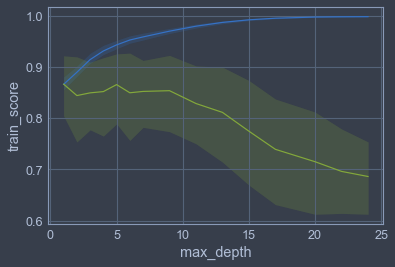

In [38]:
sns.lineplot(y='train_score', x='max_depth', data=df, label='train')
sns.lineplot(y='test_score', x='max_depth', data=df, label='test')
plt.show()

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


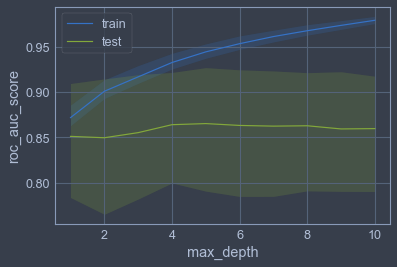

Wall time: 5min 50s


In [51]:
%%time
param_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# param_grid = [2, 5]
param_name = 'max_depth'
scores = []
for i, param in enumerate(param_grid):
    print(f"{i + 1} / {len(param_grid)}")
    scores.append(get_auc_rf_scores(X_feat_only, y_train, n_estimators=30, **{param_name: param}))
    
df = pd.DataFrame(scores, index=param_grid)
df.index.name = param_name
df = df.explode(list(df.columns)).reset_index()

sns.lineplot(x=param_name, y='train_score', data=df, label='train')
sns.lineplot(x=param_name, y='test_score', data=df, label='test')
plt.ylabel('roc_auc_score')
plt.show()

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


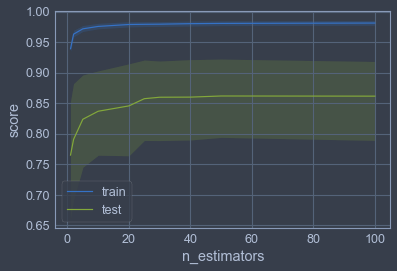

Wall time: 9min 25s


In [50]:
%%time
param_grid = [1, 2, 5, 10, 20, 25, 30, 40, 50, 100]
# param_grid = [2, 5]
param_name = 'n_estimators'
scores = []
for i, param in enumerate(param_grid):
    print(f"{i + 1} / {len(param_grid)}")
    scores.append(get_auc_rf_scores(X_feat_only, y_train, **{param_name: param}))
    
df = pd.DataFrame(scores, index=param_grid)
df.index.name = param_name
df = df.explode(list(df.columns)).reset_index()

sns.lineplot(y='train_score', x=param_name, data=df, label='train')
sns.lineplot(y='test_score', x=param_name, data=df, label='test')
plt.ylabel('roc_auc_score')
plt.show()

1 / 7
2 / 7
3 / 7
4 / 7
5 / 7
6 / 7
7 / 7


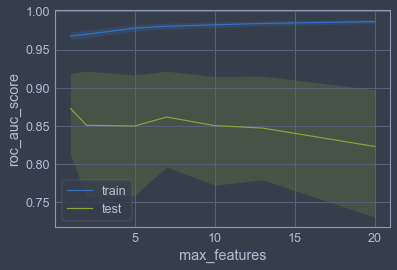

Wall time: 10min 59s


In [53]:
%%time
param_grid = [1, 2, 5, 7, 10, 13, 20]
# param_grid = [2, 5]
param_name = 'max_features'
scores = []
for i, param in enumerate(param_grid):
    print(f"{i + 1} / {len(param_grid)}")
    scores.append(get_auc_rf_scores(X_feat_only, y_train, n_estimators=50, **{param_name: param}))
    
df = pd.DataFrame(scores, index=param_grid)
df.index.name = param_name
df = df.explode(list(df.columns)).reset_index()

sns.lineplot(y='train_score', x=param_name, data=df, label='train')
sns.lineplot(y='test_score', x=param_name, data=df, label='test')
plt.ylabel('roc_auc_score')
plt.show()

In [54]:
%%time
get_auc_rf_scores(X_feat_only, y_train, max_depth=5, n_estimators=100)['test_score'].mean()

Wall time: 1min 52s


0.8673731828990621

In [58]:
%%time
X_train_new, _ = add_multi_feature(['hour', 'duration', 'delta_avg', 'weekday'], X_full)
get_auc_rf_score(X_train_new, y_train, max_depth=5, n_estimators=100)

Wall time: 39.7 s


0.8501311968623828

In [60]:
%%time
X_train_new, X_test_new = add_multi_feature(feat_df.columns, X_full)
get_auc_rf_score(X_train_new, y_train, max_depth=5, n_estimators=100)

Wall time: 1min 4s


0.8819156194958142

In [7]:
%%time
probs = predict_probs(feat_df.columns, estimator=RandomForestClassifier(random_state=17, 
                                max_depth=5, 
                                n_estimators=100))

Local score: 0.8819
Wall time: 1min 38s


In [8]:
write_to_submission_file(probs, 'logit_subm22.csv.zip')

In [9]:
feat_df.columns

Index(['weekday', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'duration', 'hour_sin', 'hour_cos', 'hour', 'morning',
       'noon', 'evening', 'night', 'delta1', 'delta2', 'delta3', 'delta4',
       'delta5', 'delta6', 'delta7', 'delta8', 'delta9', 'delta_avg'],
      dtype='object')